In [15]:
import scipy
import scipy.fftpack
import scipy.special
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import time
from numpy.fft import rfft, irfft, fft, ifft
from filamentsim import *
from pathlib import Path
import pickle
import timeit
import sys, os

In [16]:
np.seterr(all='raise')
import warnings
warnings.filterwarnings(action="error", category=np.ComplexWarning)

## Parameters

In [17]:
sim_name = 'KE_open'
scenario_name = 'test_system'

In [18]:
run_name = 'test'
dt = 1e-4
integrator = 'KE_SO3_integrator'

In [19]:
L0 = 1
L = 10
dim = 3

N = 100

Nm = N
Mm = N
Mm_render = N*20
Mm_render_cheb = N*10
Mm_save = N*10

# Generate curve

random_seed = 332325
frame_rot_ampl = 10
N_random_curve_modes = 3
mu_random_curve = 0
sigma_random_curve = 1

# System parameters

lmbd = 1

cn_k = np.array([1, 1, 1])*1e-2
cn_eps = np.array([1, 1, 1])*1e-2

# Simulation parameters

T = 0.01
taylor_tol = 1e-2

# Misc

N_save = 100
N_clock = 100
N_integrator_trials = int(1e4)

# Initial conditions

var_u_p = 1
var_u_q = 1
rand_u_n = 5

var_t_p = 1
var_t_q = 1
rand_t_n = 5

sim_folder = '/home/ltk26/dev/filament-dynamics/FINAL/notebooks/accuracy_sims/'
output_folder = '/home/ltk26/dev/filament-dynamics/FINAL/notebooks/accuracy_sims/output'

In [20]:
# Load arguments if running as a script
if sys.argv[1] == "args":
    params_pkl_path = sys.argv[2]
    args_params = pickle.load(open(params_pkl_path, 'rb'))

    for param_k, param_v in args_params.items():
        globals()[param_k] = param_v

## Initial conditions

In [21]:
Nt = int(np.round(T/dt))
ts = np.linspace(0, T, Nt)

In [22]:
path_handler = filamentsim.cheb.ChebHandler(dim, Nm, Mm, L0, mpmath_dps=-1)
path_handler_render = filamentsim.uniform.UniformHandler(dim, Mm_render, Mm_render, L0)
path_handler_cheb_render = filamentsim.cheb.ChebHandler(dim, Mm_render_cheb, Mm_render_cheb, L0, mpmath_dps=-1)

us_unif = path_handler.get_grid_unif(Mm_render, L0)
us = path_handler.grid
us_render = path_handler_render.grid

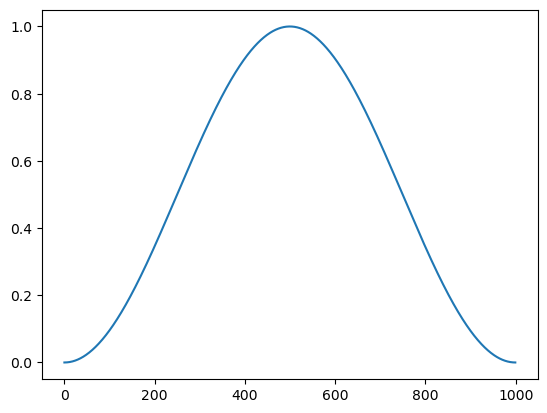

In [23]:
env = -path_handler_cheb_render.grid * (path_handler_cheb_render.grid - L0)
env = env
env /= np.max(env)
plt.plot(env)

In [24]:
if random_seed != -1:
    np.random.seed(random_seed)

In [25]:
def get_random_coeffs(var, n):
    coeffs = np.zeros(n)
    std = np.sqrt(var)
    
    for i in range(1, n):
        coeffs += std*np.random.normal() / ( np.pi*(i-0.5) )
    
    coeffs[0] = std*np.random.normal()
    
    return coeffs

In [26]:
def get_random_time_series(var, n):
    fs = np.zeros(Nt)
    for i in range(1, n):
        fs += var*np.sin((i-0.5)*np.pi*ts/T)*np.random.normal() / ( np.pi*(i-0.5) )
    fs += np.random.normal()*var
    
    return fs

def get_coeff_functions(var, rand_u_n, rand_t_n):
    coeffs = np.zeros((dim, rand_u_n, Nt))
    
    for i in range(rand_u_n):
        for j in range(dim):
            coeffs[j,i] = get_random_time_series(var, rand_t_n) 
            
    return coeffs

def compute_rand_func(ti, coeffs):
    coeff_i = coeffs[:,:,ti]
    fs = np.zeros((dim, Nm))
    
    for i in range(1, n):
        for j in range(dim):
            phi = np.sin((i-0.5)*np.pi*path_handler.grid/L0) / ( np.pi*(i-0.5) )
            fs[j,:] += phi * coeff_i[j,i]
            
    for j in range(dim):
        fs[j,:] += coeff_i[j,0]
        
    return fs

In [27]:
p_coeffs = get_coeff_functions(var_p, rand_u_n, rand_t_n)
q_coeffs = get_coeff_functions(var_p, rand_u_n, rand_t_n)

plt.plot(compute_rand_func(0, p_coeffs)[0])

NameError: name 'var_p' is not defined

In [ ]:
p = compute_rand_func(0, p_coeffs)
q = compute_rand_func(0, q_coeffs)

d

pi0 = 

In [14]:
c_th0_render = np.zeros(path_handler_cheb_render.c_shape, dtype=path_handler.dtype)
c_pi0_render = np.zeros(path_handler_cheb_render.c_shape, dtype=path_handler.dtype)

var_th = 0
var_pi = 1
n = 5

var_th /= np.sqrt(L0)
var_pi /= np.sqrt(L0)

for i in range(n):
    #for j in range(dim):
        #c_th0_render[j,:] += var_th*np.sin((i+1)*np.pi*path_handler_cheb_render.grid/L0)*np.random.normal()/(i+1)
        #c_pi0_render[j,:] += var_pi*np.sin((i+1)*np.pi*path_handler_cheb_render.grid/L0)*np.random.normal()/(i+1)
    c_th0_render[1,:] += var_th*np.sin((i+1)*np.pi*path_handler_cheb_render.grid/L0)*np.random.normal()/(i+1)
    c_pi0_render[2,:] += var_pi*np.sin((i+1)*np.pi*path_handler_cheb_render.grid/L0)*np.random.normal()/(i+1)

c_th0_render *= env
c_pi0_render *= env
        
c_th0_render[0,:] += 1

#c_th0[1] = np.sin(path_handler.grid*2*np.pi)

th0_render = c_th0_render
pi0_render = c_pi0_render

Fr0, R0, E0 = reconstruct_frame(th0_render, hat_vec_to_mat(pi0_render), L0, dus=path_handler_cheb_render.dgrid)

###

frame_rot_th = env * np.sin(2*np.pi*path_handler_cheb_render.grid/L0) * frame_rot_ampl
frame_rot_phi =  env * np.cos(2*np.pi*path_handler_cheb_render.grid/L0) * frame_rot_ampl
frame_rot_psi =  env * np.sin(4*np.pi*path_handler_cheb_render.grid/L0) * frame_rot_ampl

E_u0 = E0[...,0]

# Rotate the frame

frame_rotation = eul2rot([frame_rot_th, frame_rot_phi, frame_rot_psi])

du_frame_rotation = np.zeros(frame_rotation.shape)
for i in range(3):
    du_frame_rotation[i,:] = path_handler_cheb_render.diff_f( frame_rotation[i,:] )
    
pi0_hat_render = hat_vec_to_mat(pi0_render)

transformed_pi0_hat_render = np.einsum('iju,kju->iku', du_frame_rotation, frame_rotation)
transformed_pi0_hat_render += np.einsum('iju,jku,lku->ilu', frame_rotation, pi0_hat_render, frame_rotation)
transformed_pi0_render = hat_mat_to_vec(transformed_pi0_hat_render)

transformed_th0_render = np.einsum('iju,ju->iu', frame_rotation, th0_render)

E_u0 = E_u0.dot(frame_rotation[...,0].T)

th0_render = transformed_th0_render
pi0_render = transformed_pi0_render

# Transform back to Fourier modes

c_th0 = path_handler.cheb_to_cheb(th0_render, Mm)
c_pi0 = path_handler.cheb_to_cheb(pi0_render, Mm)

th0_render = c_th0_render = path_handler.cheb_to_unif(c_th0, Mm_render)
pi0_render = c_pi0_render = path_handler.cheb_to_unif(c_pi0, Mm_render)

####

Fr0, R0, E0 = reconstruct_frame(th0_render, hat_vec_to_mat(pi0_render), L0)

fig = plt.figure(figsize=(10,10))
plot_centerline_and_frame(R0, E0, fig=fig, N_frame=10, frame_scale=0.05)
plt.show()

FloatingPointError: underflow encountered in multiply

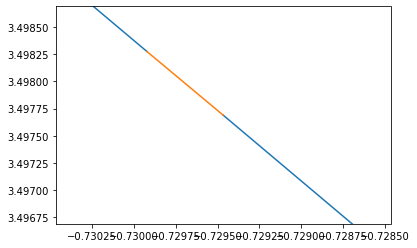

In [13]:
d = 1e-3
fig, ax = plt.subplots()
ax.plot(R0[0], R0[1])
ax.plot([R0[0,-1],R0[0,0]], [R0[1,-1],R0[1,0]])
ax.set_xlim(R0[0,-1]-d, R0[0,-1]+d)
ax.set_ylim(R0[1,-1]-d, R0[1,-1]+d)
plt.show()
plt.close()

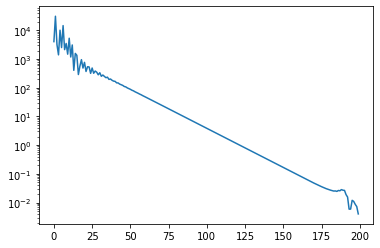

In [14]:
fig, ax = plt.subplots()
ax.plot(np.abs(c_pi0[2]))
ax.set_yscale('log')
plt.show()
plt.close()

## Define dynamics

In [15]:
def compute_F(t, th, pi, out=None):
    F = np.einsum('i,iu->iu', cn_k, th, out=out)
    F[0] -= cn_k[0]
    return F

def compute_M(t, th, pi, out=None):
    return np.einsum('i,iu->iu', cn_eps, pi, out=out)

def compute_U_T(us, th, pi):
    U_T = cn_k[0]*(th[0]-1)**2 + cn_k[1]*th[1]**2 + cn_k[2]*th[2]**2
    U_T = np.trapz(U_T, us)*0.5
    return U_T

def compute_U_R(us, th, pi):
    U_R = cn_eps[0]*pi[0]**2 + cn_eps[1]*pi[1]**2 + cn_eps[2]*pi[2]**2
    U_R = np.trapz(U_R, us)*0.5
    return U_R

def compute_U(us, th, pi):
    return compute_U_T(us, th, pi) + compute_U_R(us, th, pi)

In [16]:
U0 = compute_U(path_handler_render.grid_ext,
                      path_handler_render.get_ext_f(th0_render, c_th0_render),
                      path_handler_render.get_ext_f(pi0_render, c_pi0_render))
U_T0 = compute_U_T(path_handler_render.grid_ext,
                      path_handler_render.get_ext_f(th0_render, c_th0_render),
                      path_handler_render.get_ext_f(pi0_render, c_pi0_render))
U_R0 = compute_U_R(path_handler_render.grid_ext,
                      path_handler_render.get_ext_f(th0_render, c_th0_render),
                      path_handler_render.get_ext_f(pi0_render, c_pi0_render))

print('U:', U0)
print('U_T:', U_T0)
print('U_R:', U_R0)

U: 31.822273183836494
U_T: 0.5553433411029349
U_R: 31.26692984273356


## Simulate

In [17]:
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ["NUMEXPR_NUM_THREADS"] = '1'
os.environ["OMP_NUM_THREADS"] = '1'
pyfftw.config.NUM_THREADS = 1

In [18]:
params = {
    'T' : T,
    'dt' : dt,
    'taylor_tol' : taylor_tol,
    
    'lmbd' : lmbd,
    
    'path_handler' : path_handler,
    'path_handler_render' : path_handler_render,
    
    'c_pi0' : c_pi0,
    'c_th0' : c_th0,
    'Fr0_u0' : Fr0_u0,
    
    'F' : compute_F,
    'M' : compute_M,
    
    'U_T' : compute_U_T,
    'U_R' : compute_U_R,
    
    'N_save' : N_save,
    'Mm_save' : Mm_save,
    
    'N_clock' : N_clock,
    
    'save_ts' : False,
}

In [19]:
params['integrator'] = globals()[integrator]
sim_res = OD_simulate(params)

## Saving results

In [42]:
data_path = Path(output_folder, sim_name, scenario_name, run_name)
data_path.mkdir(parents=True, exist_ok=True)

figs_path = Path(data_path, 'figs')
figs_path.mkdir(parents=True, exist_ok=True)

In [21]:
pickle.dump(sim_res, open(Path( data_path, 'sim_res.pkl' ), 'wb'))

In [22]:
_params = dict.copy(params)

del _params['path_handler']
del _params['path_handler_render']
del _params['F']
del _params['M']
del _params['U_T']
del _params['U_R']
_params['integrator'] = integrator

pickle.dump(_params, open(Path( data_path, 'params.pkl' ), 'wb'))

### Stats

In [23]:
c_th = sim_res['c_th']
c_pi = sim_res['c_pi']
t = 0
dt = params['dt']
lmbd = params['lmbd']
taylor_tol = params['taylor_tol']

func = globals()[integrator]
lfunc = lambda: func(c_th, c_pi, t, dt, compute_F, compute_M, path_handler,
                 lmbd, taylor_tol, pre_transform=None, post_transform=None)
integrator_time_single_step = timeit.timeit(lfunc, number=N_integrator_trials)/N_integrator_trials
integrator_time = integrator_time_single_step * sim_res['Nt']
integrator_time /= 60**2

In [24]:
stats = {
    'integrator_time' : integrator_time,
    'integrator_time_single_step' : integrator_time_single_step,
    'sim_run_time' : sim_res['sim_run_time'],
    'sim_run_time2' : sim_res['sim_run_time2'],
    
    'U0' : U0,
    'U_T0' : U_T0,
    'U_R0' : U_R0,
    
    'Uf' : sim_res['U'][-1],
    'U_Tf' : sim_res['U_T'][-1],
    'U_Rf' : sim_res['U_R'][-1],
    
    'close_err_f' : sim_res['close_err_f'],
}

pickle.dump(stats, open(Path( data_path, 'stats.pkl' ), 'wb'))

In [25]:
with open(Path( data_path, 'stats.txt' ), 'w') as f:
    for k, v in stats.items():
        f.write('%s: %s\n' % (k,v))

### Figures

In [26]:
plt.rcParams['figure.facecolor'] = 'white'

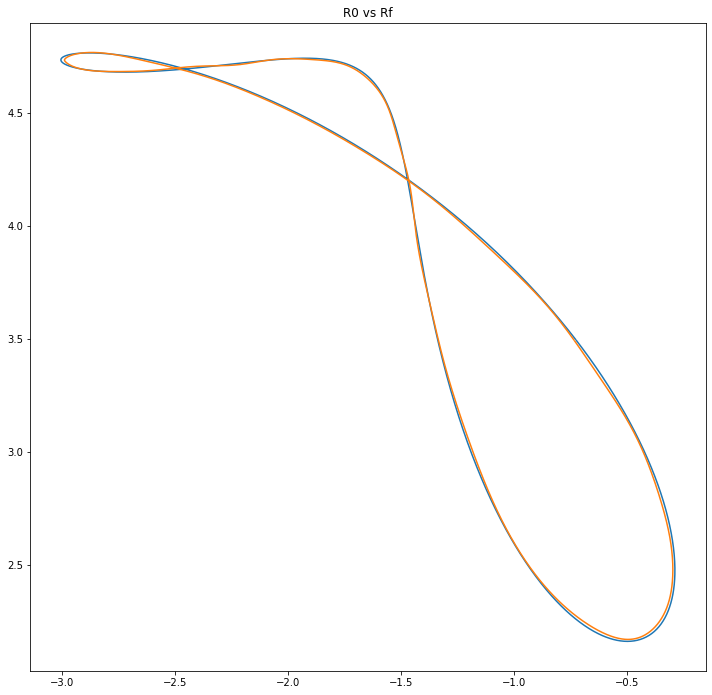

In [27]:
fig, ax = plot_centerline_2D(sim_res['saved_R'][0])
ax.set_title('R0 vs Rf')
plot_centerline_2D(sim_res['saved_R'][-1], fig=fig, ax=ax)
plt.tight_layout()
plt.show()
fig.savefig(Path( figs_path, 'R0_vs_Rf.png' ))
plt.close()

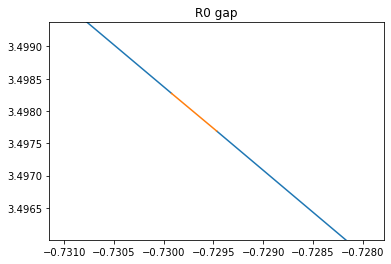

In [28]:
fig, ax = plt.subplots()
ax.set_title('R0 gap')
R = R0
d = np.linalg.norm(R[:,0] - R[:,-1])*2
ax.plot(R[0], R[1])
ax.plot([R[0,-1],R[0,0]], [R[1,-1],R[1,0]])
ax.set_xlim(R[0,-1]-d, R[0,-1]+d)
ax.set_ylim(R[1,-1]-d, R[1,-1]+d)
fig.savefig(Path( figs_path, 'R0_gap.png' ))
plt.show()
plt.close()

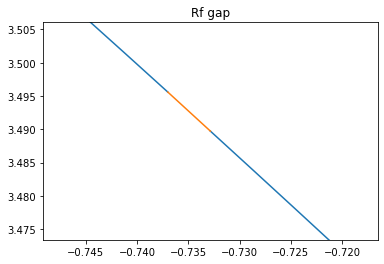

In [29]:
fig, ax = plt.subplots()
ax.set_title('Rf gap')
R = sim_res['Rf']
d = np.linalg.norm(R[:,0] - R[:,-1])*2
ax.plot(R[0], R[1])
ax.plot([R[0,-1],R[0,0]], [R[1,-1],R[1,0]])
ax.set_xlim(R[0,-1]-d, R[0,-1]+d)
ax.set_ylim(R[1,-1]-d, R[1,-1]+d)
fig.savefig(Path( figs_path, 'Rf_gap.png' ))
plt.show()
plt.close()

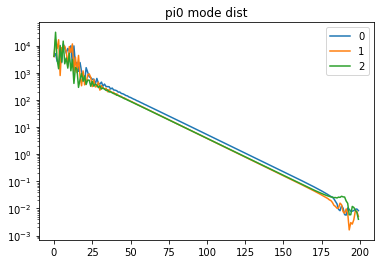

In [30]:
fig, ax = plt.subplots()
ax.set_title('pi0 mode dist')
ax.plot(np.abs(c_pi0[0]), label='0')
ax.plot(np.abs(c_pi0[1]), label='1')
ax.plot(np.abs(c_pi0[2]), label='2')
ax.set_yscale('log')
ax.legend()
fig.savefig(Path( figs_path, 'pi0_mode_dist.png' ))
plt.show()
plt.close()

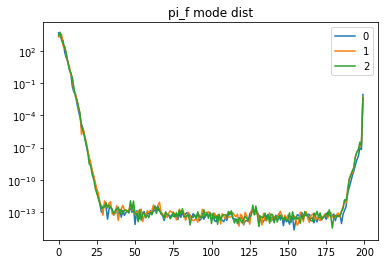

In [31]:
fig, ax = plt.subplots()
ax.set_title('pi_f mode dist')
ax.plot(np.abs(sim_res['c_pi'][0]), label='0')
ax.plot(np.abs(sim_res['c_pi'][1]), label='1')
ax.plot(np.abs(sim_res['c_pi'][2]), label='2')
ax.set_yscale('log')
ax.legend()
fig.savefig(Path( figs_path, 'pi_f_mode_dist.png' ))
plt.show()
plt.close()

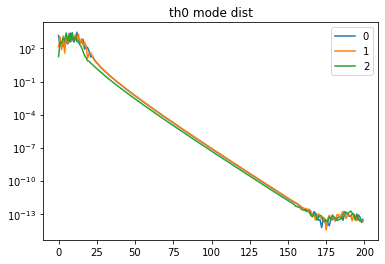

In [32]:
fig, ax = plt.subplots()
ax.set_title('th0 mode dist')
ax.plot(np.abs(c_th0[0]), label='0')
ax.plot(np.abs(c_th0[1]), label='1')
ax.plot(np.abs(c_th0[2]), label='2')
ax.set_yscale('log')
ax.legend()
fig.savefig(Path( figs_path, 'th0_mode_dist.png' ))
plt.show()
plt.close()

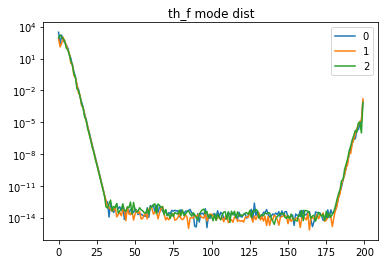

In [33]:
fig, ax = plt.subplots()
ax.set_title('th_f mode dist')
ax.plot(np.abs(sim_res['c_th'][0]), label='0')
ax.plot(np.abs(sim_res['c_th'][1]), label='1')
ax.plot(np.abs(sim_res['c_th'][2]), label='2')
ax.set_yscale('log')
ax.legend()
fig.savefig(Path( figs_path, 'th_f_mode_dist.png' ))
plt.show()
plt.close()

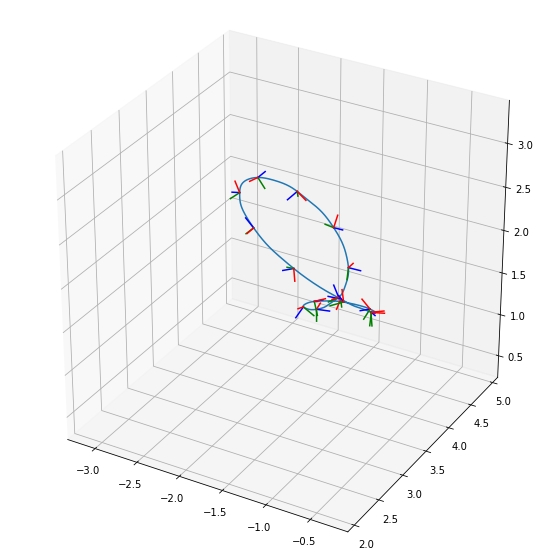

In [39]:
R = sim_res['saved_R'][0]
d = max(R[0]) - np.min(R[0])
d = max(d, np.max(R[1]) - np.min(R[1]))
d = max(d, np.max(R[2]) - np.min(R[2]))
frame_scale = d/20
N_frame = 15

vid_centerline_and_frame_3D(sim_res['saved_R'], sim_res['saved_E'],
                            save_name='%s/video.mp4' % data_path, frame_scale=frame_scale, N_frame=N_frame)
plt.show()
plt.close()